<a href="https://colab.research.google.com/github/Fer071989/loopstructural_intrusions_gmd_paper2023/blob/main/CS1%20-%20Synthetic%20Sill%20Complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fer071989/loopstructural_intrusions_gmd_paper2023.git
    !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.5
    !pip install matplotlib
    !pip install lavavu

else:
    print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


# Case Study 1 - Synthetic Sill Complex

- This synthetic example represents a sill complex composed of three sill segments. 
- Two of them propagate along the same stratigraphic contacts, while the middle one exploits a fault and step up in the stratigraphy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loop library
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer 

In [2]:
from datetime import datetime

In [3]:
lower_extent = [-100,0,0]
upper_extent = [2100, 2200, 300]

## 1. Load data

### Input DataFrame description
> feature_name = name of the geological feature to be modelled. 

> (X, Y, Z) = data points location

> coord = structural frame coordinate

> val = values of the scalar field for interpolation of geological features

> (gx, gy, gz) = gradients of structural frame scalar fields

> intrusion_contact_type = roof/top or floor/base

> intrusion_side = TRUE if lateral contact, blank if not


In [4]:
model_data = pd.read_csv('Synthetic Sill Complex.csv')
sill0_data = model_data[model_data['feature_name'] == 'sill_0'].copy()
sill1_data = model_data[model_data['feature_name'] == 'sill_1'].copy()
sill2_data = model_data[model_data['feature_name'] == 'sill_2'].copy()

## 2. Geological model

### The ``create_and_add_intrusion`` function of the ``GeologicalModel`` class creates an ``IntrusionFeature`` in two steps: 

### Step 1 - Create the intrusion frame using the ``IntrusionFrameBuilder`` class:

IntrusionFrameBuilder creates the intrusion structural frame.
This object is a curvilinear coordinate system of the intrusion body, and it has three coordinates:
> coordinate 0: it represents an approximate location of the roof or floor contact of the intrusion, and its gradient representes the growth or inflation of the magma. It is constrained using data from either the roof or floor contact. If no inflation data is available, it is assumed that the gradient of this coordinate is perpendicular to the stratigraphy.

> coordinate 1: it represents the flow direction of the intrusion. Its gradient is parallel to the propagation of the magma, which can be constrained with flow direction measurements (e.g., AMS data). In this example, we only have contact data point, so we assume the propagation was parallel to the long axis of the intrusion. 

> coordinate 2: it is parallel to the long axis of the intrusion. 

The extent of the intrusion is defined as distances along the axes of the intrusion frame.

### Step 2 - Compute threshold distances to constrain the intrusion extent, using the ``IntrusionBuilder`` class:

The IntrusionBuilder computes thresholds distances (along the structural frame coordinates) to constrain the intrusion lateral and vertical extent.

Distances along the axis of coordinate 2 are computed to constraint the intrusion lateral extent, and distances along the axis of coordinate 0 are computed to constained its vertical extent. 

Thresholds values are restricted using conceptual geometrical models representing the expected shape of the intrusion.

#### Conceptual model function to constraint lateral and vertical extent

These conceptual model are used to define the geometry of the intrusion contact where there is no data available.

They allow the modeler to integrate their interpretation of the intrusion geometry.

Considering the spatial distribution of the data, we will use an *ellipsis* to constrain it lateral extent. 
And, a *constant thickness* to represent a sill like geometry of sills

In [5]:
# Conceptual Models

def ellipse_function(
    lateral_contact_data = pd.DataFrame() , model = False, minP=None, maxP=None, minS=None, maxS=None
):
    
    if lateral_contact_data.empty:
        return model, minP, maxP, minS, maxS
    else:
        if minP == None:
            minP = lateral_contact_data["coord1"].min()
        if maxP == None:
            maxP = lateral_contact_data["coord1"].max()
        if minS == None:
            minS = lateral_contact_data["coord2"].abs().min()
        if maxS == None:
            maxS = lateral_contact_data["coord2"].max()

        a = (maxP - minP) / 2
        b = (maxS - minS) / 2

        po = minP + (maxP - minP) / 2

        p_locations = lateral_contact_data.loc[:, "coord1"].copy().to_numpy()

        s = np.zeros([len(p_locations), 2])

        s[np.logical_and(p_locations>minP, p_locations<maxP),0] =  b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 
        s[np.logical_and(p_locations>minP, p_locations<maxP),1] =  -b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 

        return s

def constant_thickness_function(othercontact_data = pd.DataFrame(), 
                                mean_growth=None, minP=None, maxP=None, minS=None, maxS=None, vertex=None):
    
    if othercontact_data.empty:
        return mean_growth
    
    if mean_growth == None:
        mean_growth = othercontact_data.loc[:,'coord1'].mean()
        
    data_ps = np.array([othercontact_data.loc[:,'coord1'], othercontact_data.loc[:,'coord2']]).T
    
    conceptual_growth = np.ones([len(data_ps),2]) * mean_growth
    
    return conceptual_growth

## Create the 3D geological model.

First, we build the host rock (conformable stratigraphy), and then we build the intrusions, whose geometry is controlled by the host rock geometry. 

In [6]:
# Create Geological Model

model = GeologicalModel(lower_extent,upper_extent)

model.nsteps = [40,40,40] # model grid
model.data = model_data

conformable_feature = model.create_and_add_foliation('stratigraphy', nelements = 3000, solver = 'lu', interpolatortype = 'FDI')
fault = model.create_and_add_fault('fault', displacement=0, nelements=2000, steps=1, interpolatortype='FDI', buffer=0.3)

Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region


In [7]:
viewer_data = LavaVuModelViewer(model, background='white')
viewer_data.add_isosurface(conformable_feature, nslices = 6, paint_with = conformable_feature)
viewer_data.add_isosurface(fault[0], isovalue = 0, colour = 'black')
viewer_data.add_points(sill0_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill 0 data', pointsize = 10)
viewer_data.add_points(sill1_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill 1 data', pointsize = 10)
viewer_data.add_points(sill2_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill 2 data', pointsize = 10)

viewer_data.rotate([-70.559, 71.941, 19.538])
viewer_data.interactive()

### Creating steps geometries in sills
To create steps geometries in the intrusions, we first need to define the stratigraphic column of the host rock. 
Using the stratigraphic column, we can specify the units where the step starts and where it ends.

> Note: The stratigraphic columns should be defined, but it could be composed of just one unit (as in this example). The algorithm will look for clusters of points to identify the two contacts within the 'unique unit' where Sill 2 is emplaced.

In [8]:
stratigraphic_column = {}
stratigraphic_column['stratigraphy'] = {}
stratigraphic_column['stratigraphy']['Unique unit'] = {'min':-np.inf,'max':+np.inf,'id':0}
model.set_stratigraphic_column(stratigraphic_column)

In [9]:
intrusion_frame_parameters = {'type' : 'interpolated', 
                              'contact' :'floor', 
                              'contact_anisotropies' : [conformable_feature]
                             }

print(datetime.now().isoformat(timespec='seconds'))
                                
Sill_0 = model.create_and_add_intrusion('sill_0', intrusion_frame_name = 'sill_0_frame',
                                        intrusion_lateral_extent_model = ellipse_function,
                                        intrusion_vertical_extent_model = constant_thickness_function,
                                        intrusion_frame_parameters = intrusion_frame_parameters,
                                        interpolatortype = 'FDI'
                                       )

print(datetime.now().isoformat(timespec='seconds'))

Sill_1 = model.create_and_add_intrusion('sill_1', intrusion_frame_name = 'sill_1_frame',
                                        intrusion_lateral_extent_model = ellipse_function,
                                        intrusion_vertical_extent_model = constant_thickness_function,
                                        intrusion_frame_parameters = intrusion_frame_parameters,
                                       interpolatortype = 'FDI'
                                       )


# The middle sill is built by adding a step to its structural frame

intrusion_steps = {}
intrusion_steps['step1'] = {'structure' : fault, 
                            'unit_from' : 'Unique unit', 'series_from': conformable_feature,
                            'unit_to' : 'Unique unit','series_to': conformable_feature,
                            
                            'g_w':0.1}


intrusion_frame_parameters['intrusion_steps'] = intrusion_steps
intrusion_frame_parameters['delta_c'] = [[5e8,10]]

print(datetime.now().isoformat(timespec='seconds'))

Sill_2 = model.create_and_add_intrusion('sill_2', intrusion_frame_name = 'sill_2_frame',
                                        intrusion_lateral_extent_model = ellipse_function,
                                        intrusion_vertical_extent_model = constant_thickness_function,
                                        intrusion_frame_parameters = intrusion_frame_parameters,
                                        interpolatortype = 'FDI'
                                       )

print(datetime.now().isoformat(timespec='seconds'))

2023-09-20T16:09:42
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
2023-09-20T16:09:42
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
2023-09-20T16:09:42
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region


C:\Users\falv0002\Anaconda3\envs\loopstructural\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ERROR: 2023-09-20 16:09:43,105: intrusion_frame_builder.py:734 -- No faults identified, you may increase the value of delta_f


2023-09-20T16:09:43


## 3. Visualisation of intrusion frame

In [10]:
viewer_frames = LavaVuModelViewer(model, background='white')

# -- add pre-intrusion faults

# viewer_frames.add_data(Sill_0.intrusion_frame[0])
# viewer_frames.add_data(Sill_0.intrusion_frame[1])
# viewer_frames.add_data(Sill_0.intrusion_frame[2])
viewer_frames.add_isosurface(Sill_0.intrusion_frame[0], isovalue = 0, colour = 'red')
viewer_frames.add_isosurface(Sill_0.intrusion_frame[1], isovalue = 0, colour = 'green')
viewer_frames.add_isosurface(Sill_0.intrusion_frame[2], isovalue = 0, colour = 'blue')

# viewer_frames.add_data(Sill_1.intrusion_frame[0])
# viewer_frames.add_data(Sill_1.intrusion_frame[1])
# viewer_frames.add_data(Sill_1.intrusion_frame[2])
viewer_frames.add_isosurface(Sill_1.intrusion_frame[0], isovalue = 0, colour = 'red')
viewer_frames.add_isosurface(Sill_1.intrusion_frame[1], isovalue = 0, colour = 'green')
viewer_frames.add_isosurface(Sill_1.intrusion_frame[2], isovalue = 0, colour = 'blue')

viewer_frames.add_data(Sill_2.intrusion_frame[0])
# viewer_frames.add_data(Sill_2.intrusion_frame[1])
# viewer_frames.add_data(Sill_2.intrusion_frame[2])
viewer_frames.add_isosurface(Sill_2.intrusion_frame[0], isovalue = 0, colour = 'red')
viewer_frames.add_isosurface(Sill_2.intrusion_frame[1], isovalue = 0, colour = 'green')
viewer_frames.add_isosurface(Sill_2.intrusion_frame[2], isovalue = 0, colour = 'blue')

# viewer_frames.add_points(sill0_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill0 data', pointsize = 5)
# viewer_frames.add_points(sill1_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill1 data', pointsize = 5)
# viewer_frames.add_points(sill2_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill2 data', pointsize = 5)


viewer_frames.ymin = 0
viewer_frames.ymax = 1
viewer_frames.xmin = 0
viewer_frames.xmax = 1
viewer_frames.rotate([-70.559, 71.941, 19.538])
viewer_frames.interactive()

## 4. Visualization of 3D Geological Model

In [11]:
nn = 50 # improve model resolution by changing this value
model.nsteps = [nn,nn,nn]

In [12]:
def paint_with(points):
    return points[:,2]

In [13]:
datetime.now().isoformat(timespec='seconds')   

'2023-09-20T16:10:38'

In [14]:
viewer = LavaVuModelViewer(model, background='white')

# add host rock
# viewer.add_isosurface(conformable_feature, nslices = 3, colour = 'grey')

# add intrusion data and intrusion contact isosurface
viewer.add_points(sill0_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill0 data', pointsize = 5)
viewer.add_points(sill1_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill1 data', pointsize = 5)
viewer.add_points(sill2_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill2 data', pointsize = 5)
viewer.add_isosurface(Sill_0, isovalue = 0, paint_with = paint_with, cmap = 'autumn')
viewer.add_isosurface(Sill_1, isovalue = 0, paint_with = paint_with, cmap = 'autumn')
viewer.add_isosurface(Sill_2, isovalue = 0, paint_with = paint_with, cmap = 'autumn')

# viewer.add_isosurface(Sill_0, isovalue = 0, colour = 'red', name = 'sill0_2')
# viewer.add_isosurface(Sill_1, isovalue = 0, colour = 'red', name = 'sill1_2')
# viewer.add_isosurface(Sill_2, isovalue = 0, colour = 'red', name = 'sill2_2')

viewer.add_isosurface(fault[0], isovalue = 0, colour = 'black')

viewer.xmin = 0 
viewer.xmax = 1 
viewer.ymin = 0 
viewer.ymax = 1 

viewer.rotate([-70.559, 71.941, 19.538])
viewer.interactive()

In [15]:
datetime.now().isoformat(timespec='seconds')   

'2023-09-20T16:10:41'

In [16]:
Sill_0.intrusion_frame.builder[0].interpolator

### 5. Check conditioning of the models

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  2.,  0.,  2.,
        21.]),
 array([-5.11590770e-13, -4.75040642e-13, -4.38490514e-13, -4.01940386e-13,
        -3.65390258e-13, -3.28840130e-13, -2.92290002e-13, -2.55739874e-13,
        -2.19189746e-13, -1.82639618e-13, -1.46089490e-13, -1.09539362e-13,
        -7.29892337e-14, -3.64391057e-14,  1.11022302e-16]),
 <BarContainer object of 14 artists>)

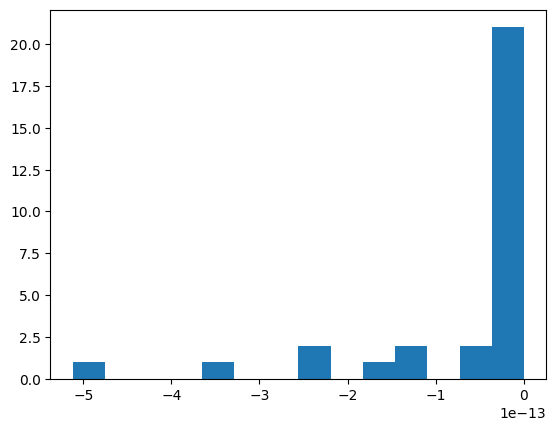

In [17]:
intrusion = Sill_2
intrusion_data = sill2_data
intrusion_data_xyz = intrusion_data.loc[:,['X','Y','Z',]].to_numpy()
df = pd.DataFrame(intrusion_data_xyz, columns =['X','Y','Z'])
sf_array = intrusion.evaluate_value(model.scale(intrusion_data_xyz, inplace=False))

import matplotlib.pyplot as plt
plt.hist(sf_array, bins='auto')

### 6. Visualize Lateral conceptual model

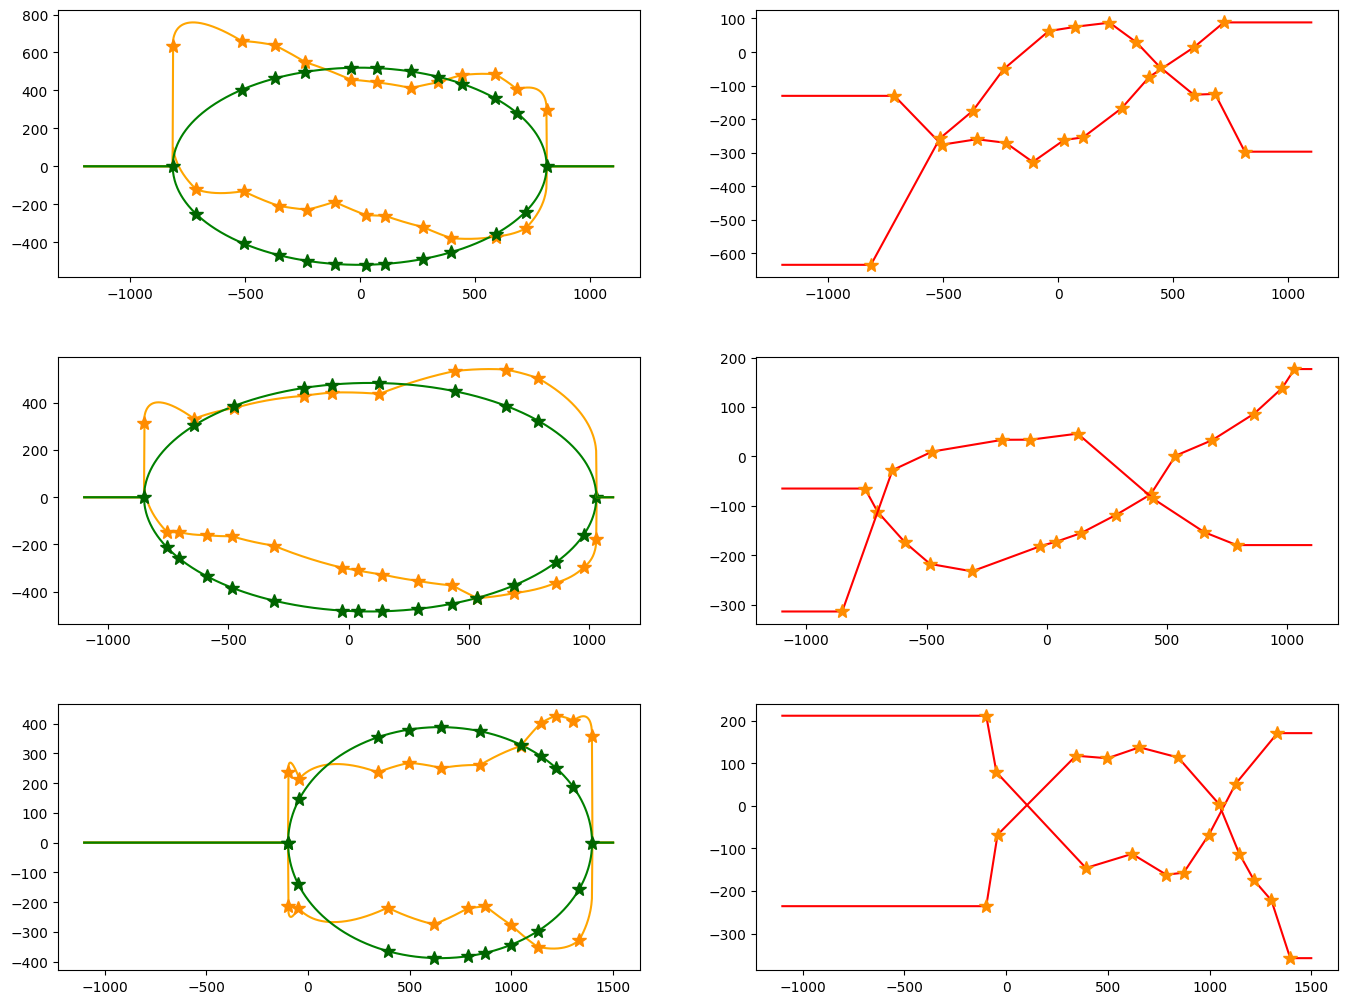

In [18]:
Sill = Sill_0
coordinate1 = np.linspace(-1200,1100,1000)

lateral_data = Sill.builder.data_for_lateral_extent_calculation
vertical_data = Sill.builder.data_for_vertical_extent_calculation
threshold_values, residual_values, conceptual_values = Sill.interpolate_lateral_thresholds(coordinate1)

plt.subplot(321) # Lateral extent simulated values and data     
plt.plot(coordinate1,threshold_values[0],"-",c='orange', markersize = 10)
plt.plot(coordinate1,conceptual_values[0],"-",c='green', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)
plt.plot(coordinate1,threshold_values[1],"-",c='orange', markersize = 10)
plt.plot(coordinate1,conceptual_values[1],"-",c='green', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)

plt.subplot(322) # Lateral extent simulated values and data     
plt.plot(coordinate1,residual_values[0],"-",c='red', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)
plt.plot(coordinate1,residual_values[1],"-",c='red', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)

Sill = Sill_1
coordinate1 = np.linspace(-1100,1100,1000)

lateral_data = Sill.builder.data_for_lateral_extent_calculation
vertical_data = Sill.builder.data_for_vertical_extent_calculation
threshold_values, residual_values, conceptual_values = Sill.interpolate_lateral_thresholds(coordinate1)

plt.subplot(323) # Lateral extent simulated values and data     
plt.plot(coordinate1,threshold_values[0],"-",c='orange', markersize = 10)
plt.plot(coordinate1,conceptual_values[0],"-",c='green', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)
plt.plot(coordinate1,threshold_values[1],"-",c='orange', markersize = 10)
plt.plot(coordinate1,conceptual_values[1],"-",c='green', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)

plt.subplot(324) # Lateral extent simulated values and data     
plt.plot(coordinate1,residual_values[0],"-",c='red', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)
plt.plot(coordinate1,residual_values[1],"-",c='red', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)

Sill = Sill_2
coordinate1 = np.linspace(-1100,1500,1000)

lateral_data = Sill.builder.data_for_lateral_extent_calculation
vertical_data = Sill.builder.data_for_vertical_extent_calculation
threshold_values, residual_values, conceptual_values = Sill.interpolate_lateral_thresholds(coordinate1)

plt.subplot(325) # Lateral extent simulated values and data     
plt.plot(coordinate1,threshold_values[0],"-",c='orange', markersize = 10)
plt.plot(coordinate1,conceptual_values[0],"-",c='green', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)
plt.plot(coordinate1,threshold_values[1],"-",c='orange', markersize = 10)
plt.plot(coordinate1,conceptual_values[1],"-",c='green', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)

plt.subplot(326) # Lateral extent simulated values and data     
plt.plot(coordinate1,residual_values[0],"-",c='red', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)
plt.plot(coordinate1,residual_values[1],"-",c='red', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=2, wspace=0.2, hspace=0.3)
plt.show()

## Plots for manuscript

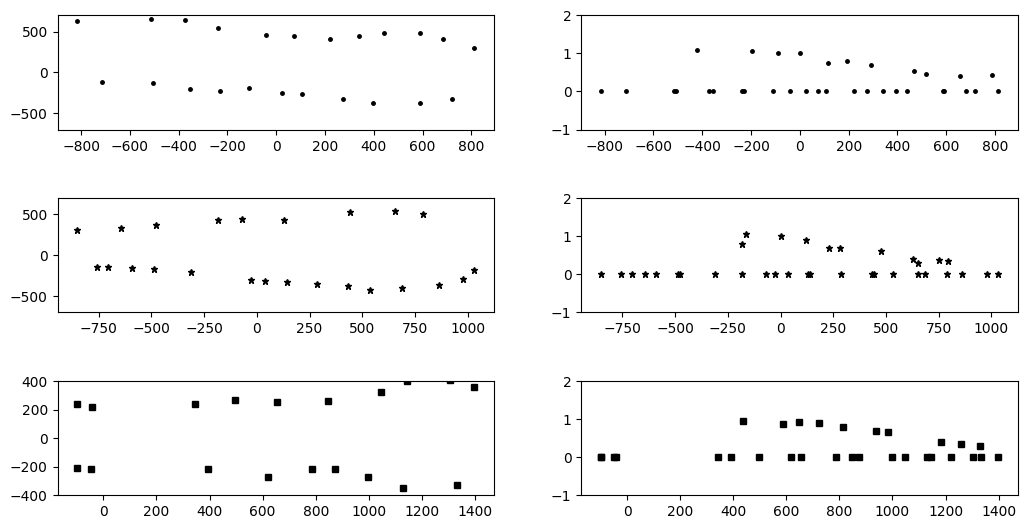

In [19]:
plt.subplot(321) # Lateral extent simulated values and data 

Sill = Sill_0
lateral_data = Sill.builder.data_for_lateral_extent_calculation
vertical_data = Sill.builder.data_for_vertical_extent_calculation
    
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],".", c='black', markersize = 5)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],".", c='black', markersize = 5)
plt.ylim([-700,700])

plt.subplot(322)
plt.plot(vertical_data[0].loc[:,'coord1'],vertical_data[0].loc[:,'coord0'],".", c='black', markersize = 5)
plt.plot(vertical_data[1].loc[:,'coord1'],vertical_data[1].loc[:,'coord0'],".", c='black', markersize = 5)
plt.ylim([-1,2])

plt.subplot(323) # Lateral extent simulated values and data 

Sill = Sill_1
lateral_data = Sill.builder.data_for_lateral_extent_calculation
vertical_data = Sill.builder.data_for_vertical_extent_calculation
    
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],"*", c='black', markersize = 5)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],"*", c='black', markersize = 5)
plt.ylim([-700,700])


plt.subplot(324)
plt.plot(vertical_data[0].loc[:,'coord1'],vertical_data[0].loc[:,'coord0'],"*", c='black', markersize = 5)
plt.plot(vertical_data[1].loc[:,'coord1'],vertical_data[1].loc[:,'coord0'],"*", c='black', markersize = 5)
plt.ylim([-1,2])

plt.subplot(325) # Lateral extent simulated values and data 

Sill = Sill_2
lateral_data = Sill.builder.data_for_lateral_extent_calculation
vertical_data = Sill.builder.data_for_vertical_extent_calculation
    
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],"s", c='black', markersize = 5)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],"s", c='black', markersize = 5)
plt.ylim([-400,400])


plt.subplot(326)
plt.plot(vertical_data[0].loc[:,'coord1'],vertical_data[0].loc[:,'coord0'],"s", c='black', markersize = 5)
plt.plot(vertical_data[1].loc[:,'coord1'],vertical_data[1].loc[:,'coord0'],"s", c='black', markersize = 5)
plt.ylim([-1,2])


plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1, wspace=0.2, hspace=.6)
plt.show()